In [ ]:
#default_exp data.datasets.favorita

# Favorita retail dataset

## Dataset Description
The 2018 Kaggle competition was organized by Corporación Favorita, a major Ecuatorian grocery retailer. The Favorita dataset is comprised of item sales history and promotions information, with additional information of items and stores,regional and national holidays, among other. 

The competition task consisted on forecasting sixteen days for the log-sales of particular item store combinations, for 210,654 series. 
The original dataset is available in the [Kaggle Competition url](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/).

During the model's optimization we consider a balanced dataset of items and stores, for 217,944 bottom level series (4,036 items * 54 stores) but we evaluate on the original 210,645 test series. We consider a geographical hierarchical structure of 4 levels corresponding to stores, cities, states, and national level for a total of 371,312 time series. The dataset is at the daily level and starts from 2013-01-01 and ends by 2017-08-15 that comprehend 1688 days, we keep 34 days (1654 to 1988 days) as hold-out test and 34 days (1620 to 1654 days) as validation.

Table of Contents
1.   [Auxiliary Functions](#cell-1)
2.   [Favorita Data class](#cell-2)
3.   [Favorita Validation](#cell-3)
4.   [HierarchicalDataset Validation](#cell-4)

Summary of Favorita's hierarchical structure

| Geographical Division | Number of nodes per division  | Number of series per division |    Total    |
|          ---          |               ---             |              ---              |     ---     |
|  Ecuador              |              1                |             4,036             |     4,036   |
|  States               |             16                |            64,576             |    64,576   |
|  Cities               |             22                |            88,792             |    88,792   |
|  Stores               |             54                |           217,944             |   217,944   |
|  Total                |             93                |           371,312             |   371,312   |


In [ ]:
# !pip install py7zr
# !pip install matplotlib
# !pip install sklearn
# !pip install pydantic
# !pip install shutil

In [ ]:
# export
import shutil
from py7zr import unpack_7zarchive
# shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)

# import mkl
# mkl.set_num_threads(56)

In [ ]:
# export
import os
import gc
import sys
import time
import tqdm
import timeit

import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# export
import logging
import requests
import subprocess
import zipfile
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

from dataclasses import dataclass
from neuralforecast.data.datasets.utils import (
    download_file, Info, TimeSeriesDataclass
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# hide
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

<a name="cell-1"></a>
## 1. Auxiliary Functions

In [ ]:
# export
class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

In [ ]:
# export        
def check_nans(df):
    """ For data wrangling logs """
    n_rows = len(df)
    
    check_df = {'col': [], 'dtype': [], 'nan_prc': []}
    for col in df.columns:
        check_df['col'].append(col)
        check_df['dtype'].append(df[col].dtype)
        check_df['nan_prc'].append(df[col].isna().sum()/n_rows)
    
    check_df = pd.DataFrame(check_df)
    print("\n")
    print(f"dataframe n_rows {n_rows}")
    print(check_df)
    print("\n")
    
def check_items(items):
    unique_items = items.unique()
    print('items.min()', items.min())
    print('items.max()', items.max())
    
def one_hot_encoding(df, index_col):    
    encoder = OneHotEncoder()
    columns = list(df.columns)
    columns.remove(index_col)
    one_hot_concat_df = pd.DataFrame(df[index_col].values, columns=[index_col])
    for col in columns:
        dummy_columns = [f'{col}_[{x}]' for x in list(df[col].unique())]
        dummy_values  = encoder.fit_transform(df[col].values.reshape(-1,1)).toarray()
        one_hot_df    = pd.DataFrame(dummy_values, columns=dummy_columns)        
        one_hot_concat_df = pd.concat([one_hot_concat_df, one_hot_df], axis=1)
    return one_hot_concat_df

def nonzero_indexes_by_row(M):
    return [np.nonzero(M[row,:])[0] for row in range(len(M))]

def numpy_balance(*arrs):
    """
    Fast NumPy implementation of balance function.
    The function creates all the interactions between
    the NumPy arrays provided.
        Parameters
        ----------
        arrs: NumPy arrays
        Returns
        -------
        out: NumPy array
    """
    N = len(arrs)
    out =  np.transpose(np.meshgrid(*arrs, indexing='ij'),
                        np.roll(np.arange(N + 1), -1)).reshape(-1, N)
    return out

def numpy_ffill(arr):
    """
    Fast NumPy implementation of forwardfill function.
    The function fills missing/nan values with the 
    following value in the array.
        Parameters
        ----------
        arr: NumPy array    
        Returns
        -------
        arr: NumPy array
    """
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

def numpy_bfill(arr):
    """
    Fast NumPy implementation of backfill function.
    The function fills missing/nan values with the 
    previous value in the array.
        Parameters
        ----------
        arr: NumPy array    
        Returns
        -------
        arr: NumPy array
    """    
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), mask.shape[1] - 1)
    idx = np.minimum.accumulate(idx[:, ::-1], axis=1)[:, ::-1]
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

In [ ]:
# export
def distance_to_holiday(holiday_dates, dates):
    # Get holidays around dates
    dates = pd.DatetimeIndex(dates)
    dates_np = np.array(dates).astype('datetime64[D]')
    holiday_dates_np = np.array(pd.DatetimeIndex(holiday_dates)).astype('datetime64[D]')

    # Compute day distance to holiday
    distance = np.expand_dims(dates_np, axis=1) - np.expand_dims(holiday_dates_np, axis=0)
    distance = np.abs(distance)
    distance = np.min(distance, axis=1)
    
    # Convert to float
    distance = distance.astype(float)
    distance = distance * (distance>0)
    
    # Fix start and end of date range
    # TODO: Think better way of fixing absence of holiday
    # It seems that the holidays dataframe has missing holidays
    distance[distance>183] = 365 - distance[distance>183]
    distance = np.abs(distance)
    distance[distance>183] = 365 - distance[distance>183]
    distance = np.abs(distance)
    distance[distance>183] = 365 - distance[distance>183]
    distance = np.abs(distance)
    distance[distance>183] = 365 - distance[distance>183]    
    
    # Scale
    distance = (distance/183) - 0.5
    # distance = (distance == 0)
    return distance

def make_holidays_distance_df(holidays_df, dates):
    #Make dataframe of distance in days to holidays
    #for holiday dates and date range
    distance_dict = {'date': dates}
    for holiday in holidays_df.description.unique():
        holiday_dates = holidays_df[holidays_df.description==holiday]['date']
        holiday_dates = holiday_dates.tolist()
        
        holiday_str = f'dist2_[{holiday}]'
        distance_dict[holiday_str] = distance_to_holiday(holiday_dates, dates)

    holidays_distance_df = pd.DataFrame(distance_dict)
    return holidays_distance_df

<a name="cell-2"></a>
## 2. Favorita Class

In [ ]:
# export
@dataclass 
class Favorita(TimeSeriesDataclass):
    # original data available from Kaggle directly
    # pip install kaggle --upgrade
    # kaggle competitions download -c favorita-grocery-sales-forecasting
    source_url = 'https://www.dropbox.com/s/fe4y1hnphb4ykpy/favorita-grocery-sales-forecasting.zip?dl=1'
    H = 34
    
    @staticmethod
    def unzip(path):
        # Unzip Load, Price, Solar and Wind data
        # shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
        files = ['holidays_events.csv.7z', 'items.csv.7z', 'oil.csv.7z', 
                 'sample_submission.csv.7z', 'stores.csv.7z', 
                 'test.csv.7z', 'train.csv.7z', 'transactions.csv.7z']
        for file in files:
            filepath = f'{path}/{file}'
            #Archive(filepath).extractall(path)
            shutil.unpack_archive(filepath, path)
            logger.info(f'Successfully decompressed {filepath}')
    
    @staticmethod            
    def download_raw(directory, source_url, decompress) -> None:
        if isinstance(directory, str):
            directory = Path(directory)
        directory.mkdir(parents=True, exist_ok=True)

        filename = source_url.split('/')[-1]
        filepath = Path(f'{directory}/{filename}')

        # Streaming, so we can iterate over the response.
        headers = {'User-Agent': 'Mozilla/5.0'}
        r = requests.get(source_url, stream=True, headers=headers)
        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0))
        block_size = 1024 #1 Kibibyte

        t = tqdm.tqdm(total=total_size, unit='iB', unit_scale=True)
        with open(filepath, 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
                f.flush()
        t.close()

        if total_size != 0 and t.n != total_size:
            logger.error('ERROR, something went wrong downloading data')

        size = filepath.stat().st_size
        logger.info(f'Successfully downloaded {filename}, {size}, bytes.')

        if decompress:
            if '.zip' in filepath.suffix:
                logger.info('Decompressing zip file...')
                with zipfile.ZipFile(filepath, 'r') as zip_ref:
                    zip_ref.extractall(directory)
            else:
                from patoolib import extract_archive
                extract_archive(filepath, outdir=directory)
            logger.info(f'Successfully decompressed {filepath}')
        
    @staticmethod
    def download(directory: str) -> None:
        """Downloads Favorita Competition Dataset."""
        if not os.path.exists(directory):
            Favorita.download_raw(directory=directory, 
                                  source_url=Favorita.source_url,
                                  decompress=True)
        if not os.path.exists(f'{directory}/train.csv'):
            Favorita.unzip(directory)
            
    @staticmethod
    def read_raw(directory):
        # Download Favorita Kaggle competition and unzip
        Favorita.download(directory)

        # We avoid memory-intensive task of infering dtypes
        dtypes_dict = dict(id='int32',
                           date='str',
                           item_nbr='int32',
                           store_nbr='int8',     # there are only 54 stores
                           unit_sales='float64', # values beyond are f32 outliers
                           onpromotion='float64')

        # We read once from csv then from feather (much faster)
        if not os.path.exists(f'{directory}/train.feather'):
            train_df = pd.read_csv(f'{directory}/train.csv',
                                  dtype=dtypes_dict,
                                  parse_dates=['date'])
            del train_df['id']
            train_df.reset_index(drop=True, inplace=True)
            train_df.to_feather(f'{directory}/train.feather')
            print("saved train.csv to train.feather for fast access")

        # Test is avoided because y_true is unavailable
        items        = pd.read_csv(f'{directory}/items.csv')
        store_info   = pd.read_csv(f'{directory}/stores.csv')        
        temporal     = pd.read_feather(f'{directory}/train.feather')
        test         = pd.read_csv(f'{directory}/test.csv', parse_dates=['date'])
        oil          = pd.read_csv(f'{directory}/oil.csv', parse_dates=['date'])
        holidays     = pd.read_csv(f'{directory}/holidays_events.csv', parse_dates=['date'])
        transactions = pd.read_csv(f'{directory}/transactions.csv', parse_dates=['date'])
        
        temporal['open'] = 1
        temporal['open'] = temporal['open'].astype('float32')      
        
        return temporal, oil, items, store_info, holidays, transactions, test
    
    @staticmethod
    def preprocess_data(directory: str, sample_size: int=100, verbose=False):
        
        with CodeTimer('Read data             ', verbose):
            # Read raw data and create ids for later use
            temporal, oil, items, store_info, holidays, transactions, test\
                           = Favorita.read_raw(directory=directory)
            
            # Hierarchically Regularized Deep Forecasting, 
            # https://arxiv.org/pdf/2106.07630.pdf
            # reported 1687 vs 1688 days (missing one time stamp)
            # date_range = pd.date_range(start_date, end_date, freq='D')
            # print('len(date_range)', len(date_range))

            temporal_dates  = temporal['date'].unique() # 1684 days
            start_date      = min(temporal_dates)
            end_date        = max(temporal_dates)
            
            # Extra H observations
            # for final H predictions (outside train)
            end_date = pd.Timestamp(end_date)
            end_date = np.datetime64(end_date + timedelta(days=34))
            #end_date = np.datetime64('2017-08-31')  # Kaggle's test last date
            
            catalog_items   = set(items['item_nbr'].unique())
            catalog_stores  = set(store_info['store_nbr'].unique())
            catalog_dates   = pd.date_range(start=start_date, 
                                            end=end_date, freq='D')
            catalog_dates   = set(catalog_dates.values.astype('datetime64[ns]'))

            temporal_dates  = set(temporal_dates)
            temporal_items  = set(temporal['item_nbr'].unique())
            temporal_stores = set(temporal['store_nbr'].unique())

            DATES  = list(catalog_dates)
            ITEMS  = list(catalog_items.intersection(temporal_items))
            STORES = list(catalog_stores.intersection(temporal_stores))

            ITEMS2 = set(test.item_nbr).intersection(set(ITEMS))
        
        with CodeTimer('Filter data           ', verbose):
            # Filter data for efficient experiments
            ITEMS = ITEMS[:sample_size]
            
            # Sort indexes
            ITEMS.sort()
            STORES.sort()
            DATES.sort()

            oil          = oil[(oil['date'] >= start_date) & (oil['date'] < end_date)]
            items        = items[items.item_nbr.isin(ITEMS)]
            store_info   = store_info[store_info.store_nbr.isin(STORES)]
            holidays     = holidays[(holidays['date'] >= start_date)\
                                    & (holidays['date'] < end_date)]
            transactions = transactions[(transactions['date'] >= start_date)\
                                        & (transactions['date'] < end_date)]
            transactions = transactions[transactions.store_nbr.isin(STORES)]

            temporal     = temporal[temporal.item_nbr.isin(ITEMS)]
            temporal     = temporal[temporal.store_nbr.isin(STORES)]
            
        with CodeTimer('Sort/Balance data     ', verbose):
            # new sorted by hierarchy store_nbr for R benchmarks
            store_info = store_info.sort_values(by=['state', 'city', 'store_nbr'])
            store_info['new_store_nbr'] = np.arange(len(store_info))

            # Share the new store id with temporal and transactions data
            new_store_nbrs = store_info[['store_nbr', 'new_store_nbr']]
            transactions   = transactions.merge(new_store_nbrs, 
                                                on=['store_nbr'], how='left')
            temporal       = temporal.merge(new_store_nbrs, 
                                            on=['store_nbr'], how='left')

            # Overwrite the store_nbr ids
            del temporal['store_nbr']
            del transactions['store_nbr']
            del store_info['store_nbr']
            
            temporal['store_nbr']     = temporal['new_store_nbr']
            transactions['store_nbr'] = transactions['new_store_nbr']
            store_info['store_nbr']   = store_info['new_store_nbr']
            del temporal['new_store_nbr']
            del transactions['new_store_nbr']
            del store_info['new_store_nbr']

            # Final Sort
            temporal     = temporal.sort_values(by=['item_nbr','store_nbr','date'])
            oil          = oil.sort_values(by=['date'])
            items        = items.sort_values(by=['item_nbr'])
            store_info   = store_info.sort_values(by=['store_nbr'])
            transactions = transactions.sort_values(by=['store_nbr','date'])

            n_items  = len(ITEMS)
            n_stores = len(STORES)
            n_dates  = len(DATES)
            
            # Create balanced item x store interaction
            balanced_prod = numpy_balance(ITEMS, STORES)
            item_store_df = pd.DataFrame(balanced_prod, columns=['item_nbr', 'store_nbr'])
            traj_nbrs     = np.arange(len(item_store_df))
            item_store_df['traj_nbr'] = np.arange(len(item_store_df))

            # Create dummy variable for original vs series introduced by
            # balance procedure and the main traj_nbr index
            idxs = temporal[['item_nbr', 'store_nbr']].values
            unique_idxs = np.unique(idxs, axis = 0)

            original_series_df = pd.DataFrame(unique_idxs, 
                                              columns=['item_nbr', 'store_nbr'])
            original_series_df['is_original'] = 1
            item_store_df = item_store_df.merge(original_series_df, 
                                                on=['item_nbr', 'store_nbr'], how='left')

            item_store_df['is_original'] = item_store_df['is_original'].fillna(0)
            
        with CodeTimer('Create H.  constraints', verbose):
            # Regional Static Variables
            store_info['country'] = 'Ecuador'
            H_df = store_info[['store_nbr', 'country', 'state', 'city']]

            # Geographic Hierarchical constraints matrix 
            # (on stores level, items x stores * items x stores does not scale)
            # Hsum : 54 stores --> 39 (country+states+cities)
            Hencoded = one_hot_encoding(df=H_df, index_col='store_nbr')
            Hsum = Hencoded.values[:, 1:] # Eliminate stores index
            H = np.concatenate((Hsum.T, np.eye(len(Hsum))), axis=0)
            
        #---------------------------- Temporal Bottom Features ------------------------------#
        # Creation of temporal bottom level (item x store x date) data based on:
        # 1. balance item x store sales 
        # 2. ffill and zfill data
        
        with CodeTimer('Create temporal_bottom', verbose):
            #-------------------- with CodeTimer('Temporal Balance') --------------------#
            # Fast numpy balance
            traj_nbrs     = item_store_df['traj_nbr'].values
            balanced_prod = numpy_balance(traj_nbrs, DATES)
            balanced_df   = pd.DataFrame(balanced_prod, columns=['traj_nbr', 'date'])
            balanced_df['date'] = balanced_df['date'].astype(temporal['date'].dtype)

            zfill_cols  = ['unit_sales'] #, 'open'] # OPEN VARIABLE FROM TFT-Google IS BAAAD
            ffill_cols  = ['onpromotion']
            filter_cols = ['item_nbr', 'store_nbr', 'date']
            filter_cols = filter_cols + zfill_cols + ffill_cols
            temporal_df = temporal.filter(items=filter_cols)

            #-------------------- with CodeTimer('Temporal Merge'): --------------------#
            # Two stage merge with balanced data
            item_store_df = item_store_df[['traj_nbr', 'item_nbr', 'store_nbr', 'is_original']]
            item_store_df.set_index(['traj_nbr'], inplace=True)
            balanced_df.set_index(['traj_nbr'], inplace=True)
            balanced_df = balanced_df.merge(item_store_df, how='left', 
                                            left_on=['traj_nbr'],
                                            right_index=True).reset_index()
            #check_nans(balanced_df)
            item_store_df = item_store_df.reset_index()        

            temporal_df.set_index(['item_nbr', 'store_nbr', 'date'], inplace=True)
            balanced_df.set_index(['item_nbr', 'store_nbr', 'date'], inplace=True)
            balanced_df = balanced_df.merge(temporal_df, how='left', 
                                            left_on=['item_nbr', 'store_nbr', 'date'],
                                            right_index=True).reset_index()
            #check_nans(balanced_df)
            del temporal_df, balanced_prod
            gc.collect()

            #-------------------- with CodeTimer('ZFill Data'): --------------------#
            for col in zfill_cols:
                balanced_df[col] = balanced_df[col].fillna(0)
            #check_nans(balanced_df)

            #-------------------- with CodeTimer('FFill Data'): --------------------#
            for col in ffill_cols:
                # Fast numpy vectorized ffill, requires balanced dataframe
                col_values = balanced_df[col].astype('float32').values
                col_values = col_values.reshape(n_items * n_stores, n_dates)
                col_values = numpy_ffill(col_values)
                col_values = numpy_bfill(col_values)
                balanced_df[col] = col_values.flatten()
                balanced_df[col] = balanced_df[col].fillna(0)
            
            #---------------- with CodeTimer('items_prob_bottom'): -----------------#
            # TODO: 'items_prob_bottom', for weighted loss -> Kaggle submission
            # TODO:  consider to keep track of bfill/ffill created observations
            balanced_df['sample_mask'] = 1
                
            temporal_bottom = balanced_df
        
        #----------------------------- Static Bottom Features -------------------------------#
        # Creation of static item store level data based on:
        # 1. Precomputed level/spread will model to "level" predictions
        # 2. Dummy variables from the geographic hierarchy
        
        with CodeTimer('Create static_bottom  ', verbose):

            #assert static_variant in ['partial', 'statistics']
            
            #if static_variant=='partial':
            static_bottom_columns = Hencoded.columns
            static_bottom = np.expand_dims(Hencoded, axis=0)
            static_bottom = np.repeat(static_bottom, repeats=len(ITEMS), axis=0)
            static_bottom = static_bottom.reshape(-1, static_bottom.shape[-1])
            static_bottom = pd.DataFrame(static_bottom, columns=static_bottom_columns)
                            
            #if static_variant=='statistics':
            Y_bottom    = temporal_bottom['unit_sales'].values
            Y_bottom    = Y_bottom.reshape((n_items*n_stores,n_dates))
            Y_available = Y_bottom[:,-34-34-60:-34-34] # skip test/validation

            # [n_regions*n_purpose, n_time] --> [n_regions*n_purpose]
            level  = np.median(Y_available, axis=1)
            spread = np.median(np.abs(Y_available - level[:,None]), axis=1)
            
            static_bottom['level'] = level
            static_bottom['spread'] = spread
            
            #static_bottom = np.concatenate([level[:,None], spread[:,None]], axis=1)
            #static_bottom = pd.DataFrame.from_records(static_bottom,
            #                                          columns=['level', 'spread'])

            static_items_bottom  = np.repeat(np.array(ITEMS), len(STORES))
            static_stores_bottom = np.tile(np.array(STORES), len(ITEMS))
            static_bottom['item_nbr']  = static_items_bottom
            static_bottom['store_nbr'] = static_stores_bottom

            static_bottom = static_bottom.merge(item_store_df, 
                                                on=['item_nbr', 'store_nbr'], how='left')
            
            level_rep = np.repeat(level, n_dates)
            temporal_bottom['is_original'] = temporal_bottom['is_original'] * level_rep
            
        #------------------------------- Static Agg Features --------------------------------#
        # Creation of static item national level data based on:
        # 1. Item characteristics, groupings dummies
            
        with CodeTimer('Create static_agg     ', verbose):
            static_agg = one_hot_encoding(df=items, index_col='item_nbr')

            # Add weight for loss perishable 1.25 and normal 1.0
            # https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview/evaluation
            static_agg['prob']    = np.ones(len(static_agg)) +\
                                    0.25 * static_agg["perishable_[1]"]
            static_bottom['prob'] = np.repeat(static_agg['prob'].values, len(STORES))

            # Transform into category for LGBM
            static_cat_agg = items

            static_cat_agg = static_cat_agg.set_index(['item_nbr'])
            for feature in static_cat_agg.columns:
                static_cat_agg[feature] = pd.Series(static_cat_agg[feature], dtype="category")

            static_cat_agg.reset_index(inplace=True)            
                
        #------------------------------ Temporal Agg Features -------------------------------#
        # Creation of temporal agg level (item x store x date) data based on:
        # 1. balance item x store sales
        # 2. ffill and zfill data
        # Curate aggregated data from oil, calendar and transactions
        
        with CodeTimer('Create temporal_agg   ', verbose):
            normalizer  = preprocessing.StandardScaler()

            #-------------------- with CodeTimer('1. Temporal'): --------------------#    
            # National sales per item
            balanced_prod = numpy_balance(ITEMS, DATES)
            balanced_df = pd.DataFrame(balanced_prod, columns=['item_nbr', 'date'])
            balanced_df['item_nbr'] = balanced_df['item_nbr'].astype(ITEMS[0].dtype)
            balanced_df['date'] = balanced_df['date'].astype(DATES[0].dtype)

            # collapse store dimension -> national
            unit_sales  = temporal_bottom[['unit_sales']].values
            unit_sales  = unit_sales.reshape(len(ITEMS), len(STORES), len(DATES), 1)
            unit_sales  = np.sum(unit_sales, axis=1)
            balanced_df['unit_sales'] = unit_sales.reshape(-1, 1)

            temporal_agg = balanced_df

            #-------------------- with CodeTimer('2. Oil'): --------------------#
            balanced_df = pd.DataFrame({'date': DATES})
            balanced_df = balanced_df.merge(oil, on='date', how='left')
            #check_nans(balanced_df)

            balanced_df['dcoilwtico'] = balanced_df['dcoilwtico'].fillna(method='ffill')
            balanced_df['dcoilwtico'] = balanced_df['dcoilwtico'].fillna(method='bfill')

            #check_nans(balanced_df)
            oil_agg = balanced_df
            oil_agg['dcoilwtico'] = normalizer.fit_transform(oil_agg['dcoilwtico'].values[:,None])

            #-------------------- with CodeTimer('3. Holidays'): --------------------#
            # Calendar Variables
            calendar = pd.DataFrame({'date': DATES})
            calendar['day_of_week']  = calendar['date'].dt.dayofweek
            calendar['day_of_month'] = calendar['date'].dt.day
            calendar['month']        = calendar['date'].dt.month

            calendar['day_of_week']  = calendar['day_of_week'].astype('float64')
            calendar['day_of_month'] = calendar['day_of_month'].astype('float64')
            calendar['month']        = calendar['month'].astype('float64')

            calendar['day_of_week']  = normalizer.fit_transform(calendar['day_of_week'].values[:,None])
            calendar['day_of_month'] = normalizer.fit_transform(calendar['day_of_month'].values[:,None])
            calendar['month'] = normalizer.fit_transform(calendar['month'].values[:,None])
            
            # Add weekly seasonality to bottom
            #temporal_bottom = calendar[['date','day_of_week']].merge(temporal_bottom,
            #                                                         on=['date'], how='left')

            # Holiday variables
            hdays = holidays[holidays['transferred']==False].copy()
            hdays.rename(columns={'type': 'holiday_type'}, inplace=True)

            national_hdays = hdays[hdays['locale']=='National']    
            national_hdays = national_hdays[national_hdays.holiday_type.isin(['Holiday', 'Transfer'])]
            national_hdays = make_holidays_distance_df(national_hdays, DATES)

            calendar_agg   = calendar.merge(national_hdays, on=['date'], how='left')

            #-------------------- with CodeTimer('4. Transactions'): --------------------#
            # Fast numpy balance
            balanced_prod       = numpy_balance(STORES, DATES)
            balanced_df         = pd.DataFrame(balanced_prod, columns=['store_nbr', 'date'])
            balanced_df['date'] = balanced_df['date'].astype('datetime64[ns]')

            # 'Transactions Merge'
            # Merge with balanced data
            transactions.set_index(['store_nbr', 'date'], inplace=True)
            balanced_df.set_index(['store_nbr', 'date'], inplace=True)
            transactions = balanced_df.merge(transactions, how='left',
                                             left_on=['store_nbr', 'date'],
                                             right_index=True).reset_index()
            #check_nans(transactions)

            transactions = transactions.sort_values(by=['store_nbr', 'date'])
            trans_values = transactions.transactions.values

            trans_values = trans_values.reshape(n_stores, n_dates)
            trans_values = numpy_ffill(trans_values)
            trans_values = np.nan_to_num(trans_values)
            trans_values = trans_values.T
            trans_values = trans_values > 0 
            trans_columns = [f'transactions_store_[{x}]' for x in STORES]

            transactions_agg = pd.DataFrame(trans_values, columns=trans_columns)
            transactions_agg['date'] = DATES

            del balanced_prod, balanced_df
            gc.collect()

            #-------------------- with CodeTimer('5. temporal_agg'): --------------------#
            #print("1. temporal_agg.shape", temporal_agg.shape)
            #print("2. oil_agg.shape", oil_agg.shape)
            #print("3. calendar_agg.shape", calendar_agg.shape)
            #print("4. transactions_agg.shape", transactions_agg.shape)
            #print("\n\n")
            #print("1. temporal_agg.dtypes \n", temporal_agg.dtypes, "\n")
            #print("2. oil_agg.dtypes \n", oil_agg.dtypes, "\n")
            #print("3. calendar_agg.dtypes \n", calendar_agg.dtypes, "\n")
            #print("4. transactions_agg.dtypes \n", transactions_agg.dtypes, "\n")

            temporal_agg.set_index(['date'], inplace=True)
            oil_agg.set_index(['date'], inplace=True)
            calendar_agg.set_index(['date'], inplace=True)
            transactions_agg.set_index(['date'], inplace=True)

            # Compile national aggregated data
            temporal_agg = temporal_agg.merge(oil_agg, how='left', left_on=['date'],
                                        right_index=True)#.reset_index()
            temporal_agg = temporal_agg.merge(calendar_agg, how='left', left_on=['date'],
                                        right_index=True)#.reset_index()
            temporal_agg = temporal_agg.merge(transactions_agg, how='left', left_on=['date'],
                                        right_index=True)#.reset_index()
            temporal_agg = temporal_agg.reset_index()
            
            calendar_agg2 = calendar_agg[['day_of_week', 'day_of_month', 
                                          'dist2_[Primer dia del ano]', 
                                          'dist2_[Navidad]']]
            temporal_bottom = temporal_bottom.merge(calendar_agg2, how='left', left_on=['date'],
                                        right_index=True)
            temporal_bottom = temporal_bottom.reset_index()

        # Checking dtypes correctness
        #if verbose:
            #print('1. static_agg.dtypes \n', static_agg.dtypes)
            #print('2. temporal_agg.dtypes \n', temporal_agg.dtypes)
            #print('3. static_bottom.dtypes \n', static_bottom.dtypes)
            #print('4. temporal_bottom.dtypes \n', temporal_bottom.dtypes)
        
        # Save feathers for fast access
        H_df.to_csv(f'{directory}/H_df.csv', index=False)
        static_agg.to_feather(f'{directory}/{str(sample_size)}_static_agg.feather')
        temporal_agg.to_feather(f'{directory}/{str(sample_size)}_temporal_agg.feather')
        static_bottom.to_feather(f'{directory}/{str(sample_size)}_static_bottom.feather')
        temporal_bottom.to_feather(f'{directory}/{str(sample_size)}_temporal_bottom.feather')
        np.save(f'{directory}/{sample_size}_hier_constraints.npy', H)
        #item_store_df.to_csv(f'{DATA_FOLDER}/{SAMPLE_SIZE}_item_store.csv')
    
    @staticmethod
    def load_process(directory=str, sample_size=int, verbose=False) -> dict:
        
        with CodeTimer('Reading data           ', verbose):
            # Data is assumed to be ordered
            static_agg      = pd.read_feather(f'{directory}/{sample_size}_static_agg.feather')
            temporal_agg    = pd.read_feather(f'{directory}/{sample_size}_temporal_agg.feather')

            static_bottom   = pd.read_feather(f'{directory}/{sample_size}_static_bottom.feather')
            temporal_bottom = pd.read_feather(f'{directory}/{sample_size}_temporal_bottom.feather')

            # Extract datasets dimensions for later use
            dates      = pd.to_datetime(temporal_agg.date.unique())
            unique_ids = static_bottom.traj_nbr.values
            item_ids   = static_bottom.item_nbr.values
            store_ids  = static_bottom.store_nbr.values
            n_time     = len(dates)                            # 1688
            n_items    = len(static_bottom.item_nbr.unique())  # sample_size=100
            n_stores   = len(static_bottom.store_nbr.unique()) # 54
            
        #-------------------------------------- S/X/Y_agg    --------------------------------------#        
        with CodeTimer('Process temporal_agg   ', verbose):
            # Drop observation indexes and obtain column indexes
            temporal_agg.drop(labels=['item_nbr', 'date'], axis=1, inplace=True)
            xcols_agg = temporal_agg.columns
        
            X_agg  = temporal_agg.values            
            Y_agg  = temporal_agg['unit_sales'].values

            X_agg  = X_agg.reshape((n_items,n_time,temporal_agg.shape[1]))
            Y_agg  = Y_agg.reshape((n_items,n_time,1))
                        
            xcols_hist_agg = list(temporal_agg.columns)
                        
            xcols_futr_agg = ['dcoilwtico',
                              'day_of_week',
                              'day_of_month',
                              'month',
                              'dist2_[Primer dia del ano]',
                              'dist2_[Carnaval]',
                              'dist2_[Viernes Santo]',
                              'dist2_[Dia del Trabajo]',
                              'dist2_[Batalla de Pichincha]',
                              'dist2_[Primer Grito de Independencia]',
                              'dist2_[Traslado Independencia de Guayaquil]',
                              'dist2_[Dia de Difuntos]',
                              'dist2_[Independencia de Cuenca]',
                              'dist2_[Navidad]',
                              'dist2_[Independencia de Guayaquil]',
                              'dist2_[Traslado Batalla de Pichincha]',
                              'dist2_[Traslado Primer Grito de Independencia]',
                              'dist2_[Traslado Primer dia del ano]']

        with CodeTimer('Process static_agg     ', verbose):
            items_prob_agg = static_agg.prob.values
            S_agg = static_agg.drop(labels=['item_nbr', 'prob'], axis=1)
            scols_agg = S_agg.columns
            S_agg = S_agg.values
        
        del temporal_agg, static_agg
        gc.collect()
        
        #-------------------------------------- S/X/Y --------------------------------------#
        with CodeTimer('Process temporal_bottom', verbose):
            stores    = static_bottom.store_nbr.unique()
            items     = static_bottom.item_nbr.unique()
            n_stores  = len(stores)

            temporal_bottom.drop(labels=['item_nbr', 'store_nbr', 'traj_nbr', 'date'], 
                                 axis=1, inplace=True)
            n_features = temporal_bottom.shape[1]
            xcols      = temporal_bottom.columns
            X_stores   = temporal_bottom.values
            Y_stores   = temporal_bottom['unit_sales'].values
            
            # temporal_bottom assumes to be balanced ie len(Y) = n_items*n_stores*n_time
            # temporal_bottom assumes to be sorted by n_items, n_zip1, n_zip2, n_time
            X  = X_stores.reshape((n_items,n_stores,n_time,n_features))
            Y  = Y_stores.reshape((n_items,n_stores,n_time))
            
            #Reshape to match with the PMM model's inputs
            #n_items, n_stores, n_time, n_features -> n_items, n_time, n_stores, n_features
            X = np.transpose(X, (0, 2, 1, 3))
            Y = np.transpose(Y, (0, 2, 1))
            
            xcols_hist = ['unit_sales'] # 'open' seems a bad variable
            xcols_futr = ['onpromotion', 'is_original']
            xcols_futr = xcols_futr + ['day_of_week', 'day_of_month', 
                                       'dist2_[Primer dia del ano]', 
                                       'dist2_[Navidad]']
        
        with CodeTimer('Process static_bottom  ', verbose):
            items_bottom      = static_bottom.item_nbr.values
            stores_bottom     = static_bottom.store_nbr.values
            items_prob_bottom = static_bottom.prob.values
            
            static_bottom.drop(labels=['item_nbr', 'store_nbr', 
                                       'traj_nbr', 'is_original', 'prob'], 
                               axis=1, inplace=True)
            scols = static_bottom.columns
            
            S = static_bottom.values
            S = S.reshape(n_items,n_stores, static_bottom.shape[1])
        
        with CodeTimer('Hier constraints       ', verbose):
            # Read hierarchical constraints dataframe
            # Create hierarchical aggregation numpy
            H_df = pd.read_csv(f'{directory}/H_df.csv')
            Hencoded = one_hot_encoding(df=H_df, index_col='store_nbr')
            Hsum = Hencoded.values[:, 1:].T # Eliminate stores index
            H = np.concatenate((Hsum, np.eye(len(stores))), axis=0)
            hier_linked_idxs = nonzero_indexes_by_row(H.T)
            
            # Aggregate the store dimension into cities, states, national
            Y_hier = np.einsum('hij,jk->hik', Y, H.T)
            hier_labels = list(Hencoded.columns[1:]) + list(H_df.store_nbr)
            hier_labels = np.array(hier_labels)
            hier_idxs = [range(93), 
                         range(0, 1), range(1, 17), 
                         range(17, 39), range(39, 93)]
            
            # Flat Bottom values for evaluation
            # n_items, n_time, n_group,n_features --> n_items*n_group, n_time, n_features
            X_flat  = temporal_bottom.values
            Y_flat  = temporal_bottom['unit_sales'].values
            
            n_features = X_flat.shape[1]
            X_flat = X_flat.reshape(n_items*n_stores, n_time, n_features)
            Y_flat = Y_flat.reshape(-1,n_time)
            
        del temporal_bottom, static_bottom
        gc.collect()            
        
        #------------------------------------- Logs and Output ------------------------------------#
        
        with CodeTimer('Final processing       ', verbose):
            # NaiveSeasonal compatibility X_futr indexing
            # Consider T0=0, L=8, H=3 and Y=[0,1,2,3,4,5,6,7|,8,9,10,11]
            # T0=0 --> [0,1,2,3,4,5,6,7|,8,9,10]
            # T0=1 --> [1,2,3,4,5,6,7,8|9,10,11]
            # T0=1 uses T0+1 X_futr=[2,3,4,5,6,7,8,9|10,11,12] ???
            # Seasonal Naive12 switch to [-1] for Naive1
            X = np.concatenate((X, X[:,[-1],:]), axis=1)
            X_agg = np.concatenate((X_agg, X_agg[:,[-1],:]), axis=1)
            
            # Reshape NumPy arrays for Pytorch inputs
            # [0,1,2,3][G,T,N,C] -> [0,2,3,1][G,N,C,T]
            S_agg = np.float32(S_agg)
            Y_agg = np.float32(np.transpose(Y_agg, (0, 2, 1)))
            X_agg = np.float32(np.transpose(X_agg, (0, 2, 1)))
            
            S = np.float32(S)
            Y = np.float32(np.transpose(Y, (0, 2, 1)))
            X = np.float32(np.transpose(X, (0, 2, 3, 1)))
            
            Y_hier = np.float32(np.transpose(Y_hier, (0, 2, 1)))
            
            # Skip NAs from Y data [G,N,T]            
            Y = Y[:,:,:-34]
            Y_agg = Y_agg[:,:,:-34]
            Y_hier = Y_hier[:,:,:-34]
        
        print('\n')
        print('TODO: add weights as prob for loss?')
        print('TODO: do bfill onpromotion rather than ffill (future)')
        
        # Assert that the variables are contained in the column indexes
        assert all(c in list(xcols_agg) for c in xcols_hist_agg)
        assert all(c in list(xcols_agg) for c in xcols_futr_agg)
        assert all(c in list(xcols) for c in xcols_hist)
        assert all(c in list(xcols) for c in xcols_futr)        
        
        data = {# Bottom data
                'S': S, 'X': X, 'Y': Y,
                'scols': scols,
                'xcols': xcols,
                'xcols_hist': xcols_hist,
                'xcols_futr': xcols_futr,
                'xcols_sample_mask': 'sample_mask', # TODO: 'items_prob_bottom'
                'xcols_available_mask': 'is_original', # availability store x item level
                # Aggregate data
                'S_agg': S_agg, 'X_agg': X_agg, 'Y_agg': Y_agg,
                'scols_agg': scols_agg,
                'xcols_agg': xcols_agg,
                'xcols_hist_agg': xcols_hist_agg,
                'xcols_futr_agg': xcols_futr_agg,
                'items_prob_agg': items_prob_agg,
                # Hierarchical data for evaluation
                'Y_flat': Y_flat,
                'X_flat': X_flat,
                'Y_hier': Y_hier,
                'hier_idxs': hier_idxs,
                'hier_labels': hier_labels,
                'hier_linked_idxs': hier_linked_idxs,
                # Shared data
                'H': H,
                'dates': dates,
                'unique_ids': unique_ids,
                'items_ids': item_ids,
                'store_ids': store_ids}   
        
        if verbose:
            print('\n')
            print(f'Total days {len(dates)}, train {n_time-34-34} validation {34}, test {34}')
            print(f'Whole dates: \t\t [{min(dates)}, {max(dates)}]')
            print(f'Validation dates: \t '+\
                  f'[{min(dates[n_time-34-34:n_time-34])}, {max(dates[n_time-34-34:n_time-34])}]')
            print(f'Test dates: \t\t [{min(dates[n_time-34:])}, {max(dates[n_time-34:])}]')
            print('\n')
            print(' '*35 +'BOTTOM')
            print('S.shape (n_items,n_stores,n_features):        \t' + str(data['S'].shape))
            print('X.shape (n_items,n_stores,n_features,n_time): \t' + str(data['X'].shape))
            print('Y.shape (n_items,n_stores,n_time):            \t' + str(data['Y'].shape))
            #print(f"scols ({len(scols)}) {data['scols']}")
            #print(f"xcols ({len(xcols)}) {data['xcols']}")
            #print(f"xcols_hist ({len(xcols_hist)}) {data['xcols_hist']}")
            #print(f"xcols_futr ({len(xcols_futr)}) {data['xcols_futr']}")
            print(' '*35 +'AGGREGATE')
            print('S_agg.shape (n_items,n_features):         \t' + str(data['S_agg'].shape))
            print('X_agg.shape (n_items,n_features,n_time):  \t' + str(data['X_agg'].shape))
            print('Y_agg.shape (n_items,n_features,n_time):  \t' + str(data['Y_agg'].shape))
            #print(f"scols_agg ({len(scols_agg)}) {data['scols_agg'][:4]}")
            #print(f"xcols_agg ({len(xcols_agg)}) {data['xcols_agg']}")
            #print(f"xcols_hist_agg ({len(xcols_hist_agg)}) {data['xcols_hist_agg']}")
            #print(f"xcols_futr_agg ({len(xcols_futr_agg)}) {data['xcols_futr_agg']}")
            print(' '*35 +'HIERARCHICAL')
            print('Y_hier.shape (n_items,n_stores,n_time):  \t' + str(data['Y_hier'].shape))
            #print('hier_idxs', hier_idxs)
            print('overall.shape'+5*'\t',  data['Y_hier'][:,hier_idxs[0],:].shape)
            print('country.shape'+5*'\t',  data['Y_hier'][:,hier_idxs[1],:].shape)
            print('states.shape '+5*'\t',  data['Y_hier'][:,hier_idxs[2],:].shape)
            print('cities.shape '+5*'\t',  data['Y_hier'][:,hier_idxs[3],:].shape)
            print('stores.shape '+5*'\t',  data['Y_hier'][:,hier_idxs[4],:].shape)
            
        return data

# directory = './data/hierarchical/favorita'
# Favorita.preprocess_data(directory=directory, sample_size=100, verbose=True)
# data = Favorita.load_process(directory=directory, sample_size=100, verbose=True)

<a name="cell-3"></a>
## 3. Favorita Validation

### 3.1 Load and Process data

In [ ]:
# from neuralforecast.data.datasets.favorita import Favorita

# directory = './data/hierarchical/favorita'
# Favorita.preprocess_data(directory=directory, sample_size=100, verbose=False)
# data = Favorita.load_process(directory=directory, sample_size=100, verbose=True)

Code block 'Reading data           ' took:	0.65551 seconds
Code block 'Process temporal_agg   ' took:	0.29934 seconds
Code block 'Process static_agg     ' took:	0.00081 seconds
Code block 'Process temporal_bottom' took:	0.67581 seconds
Code block 'Process static_bottom  ' took:	0.00142 seconds
Code block 'Hier constraints       ' took:	0.91082 seconds
Code block 'Final processing       ' took:	1.22757 seconds


TODO: add weights as prob for loss?
TODO: do bfill onpromotion rather than ffill (future)


Total days 1722, train 1654 validation 34, test 34
Whole dates: 		 [2013-01-01 00:00:00, 2017-09-18 00:00:00]
Validation dates: 	 [2017-07-13 00:00:00, 2017-08-15 00:00:00]
Test dates: 		 [2017-08-16 00:00:00, 2017-09-18 00:00:00]


                                   BOTTOM
S.shape (n_items,n_stores,n_features):        	(100, 54, 41)
X.shape (n_items,n_stores,n_features,n_time): 	(100, 54, 9, 1723)
Y.shape (n_items,n_stores,n_time):            	(100, 54, 1688)
                            

### 3.2 Validate data with plots.

#### Checking Hierarchical aggregation matrix

In [ ]:
# data['hier_labels']

array(['country_[Ecuador]', 'state_[Azuay]', 'state_[Bolivar]',
       'state_[Chimborazo]', 'state_[Cotopaxi]', 'state_[El Oro]',
       'state_[Esmeraldas]', 'state_[Guayas]', 'state_[Imbabura]',
       'state_[Loja]', 'state_[Los Rios]', 'state_[Manabi]',
       'state_[Pastaza]', 'state_[Pichincha]', 'state_[Santa Elena]',
       'state_[Santo Domingo de los Tsachilas]', 'state_[Tungurahua]',
       'city_[Cuenca]', 'city_[Guaranda]', 'city_[Riobamba]',
       'city_[Latacunga]', 'city_[Machala]', 'city_[Esmeraldas]',
       'city_[Daule]', 'city_[Guayaquil]', 'city_[Libertad]',
       'city_[Playas]', 'city_[Ibarra]', 'city_[Loja]', 'city_[Babahoyo]',
       'city_[Quevedo]', 'city_[El Carmen]', 'city_[Manta]',
       'city_[Puyo]', 'city_[Cayambe]', 'city_[Quito]', 'city_[Salinas]',
       'city_[Santo Domingo]', 'city_[Ambato]', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24'

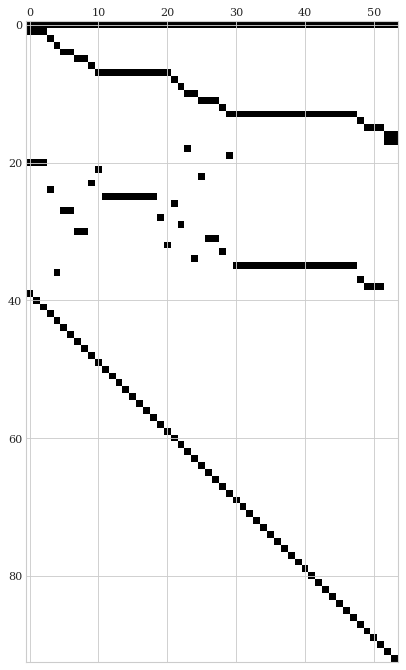

In [ ]:
# plt.figure(num=1, figsize=(6, 15), dpi=80, facecolor='w')
# plt.spy(data['H'])
# plt.show()
# plt.close()

#### Checking pre-estimated levels seasons S_bottom

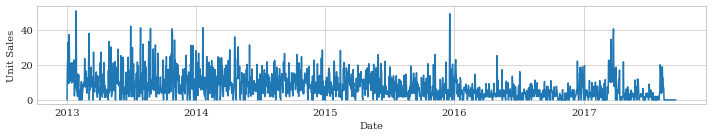

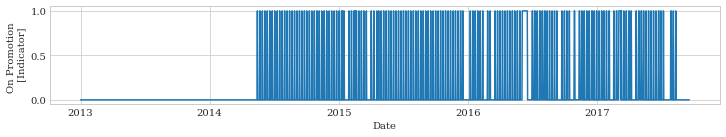

In [ ]:
# dates = data['dates']
# X = data['X']
# xcols = data['xcols']
# item_idx = 10
# store_idx = 31

# # Target variable (unit sales)
# unitsales_idx = xcols.get_loc('unit_sales')

# plt.figure(figsize=(12, 1.8))
# plt.plot(dates, X[item_idx, store_idx, unitsales_idx, :-1])
# plt.ylabel('Unit Sales')
# plt.xlabel('Date')
# plt.show()
# plt.close()

# # On promotion
# onpromotion_idx = xcols.get_loc('onpromotion')

# plt.figure(figsize=(12, 1.8))
# plt.plot(dates, X[item_idx, store_idx, onpromotion_idx, :-1])
# plt.ylabel('On Promotion \n [Indicator]')
# plt.xlabel('Date')
# plt.show()
# plt.close()

#### Checking S/Y/X_agg

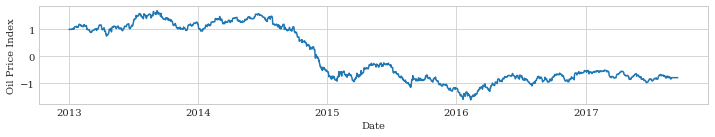

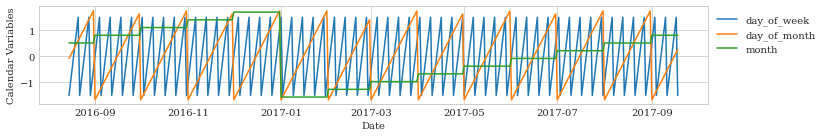

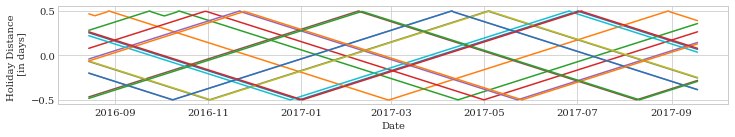

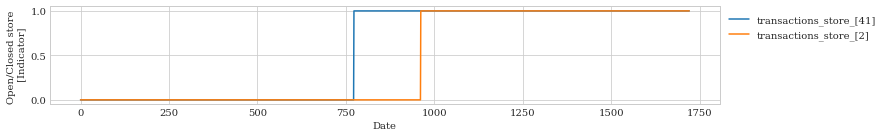

In [ ]:
# X_agg = data['X_agg']
# xcols_agg = data['xcols_agg']
# dates = data['dates']

# # Plot oil temporal exogenous
# item_idx =0
# oil_idx = xcols_agg.get_loc('dcoilwtico')

# plt.figure(figsize=(12, 1.8))
# plt.plot(dates, X_agg[item_idx, oil_idx, :-1])
# plt.ylabel('Oil Price Index')
# plt.xlabel('Date')
# plt.show()
# plt.close()

# # Plot calendar variables
# day_of_week_idx = xcols_agg.get_loc('day_of_week')
# day_of_month_idx = xcols_agg.get_loc('day_of_month')
# month_idx = xcols_agg.get_loc('month')

# plt.figure(figsize=(12, 1.8))
# plt.plot(dates[-400:], X_agg[item_idx, day_of_week_idx, -401:-1], label='day_of_week')
# plt.plot(dates[-400:], X_agg[item_idx, day_of_month_idx, -401:-1], label='day_of_month')
# plt.plot(dates[-400:], X_agg[item_idx, month_idx, -401:-1], label='month')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.ylabel('Calendar Variables')
# plt.xlabel('Date')
# plt.show()
# plt.close()

# # Plot holidays
# holidays = ['dist2_[Primer dia del ano]', 'dist2_[Carnaval]', 'dist2_[Viernes Santo]', 
#             'dist2_[Dia del Trabajo]', 'dist2_[Batalla de Pichincha]', 
#             'dist2_[Primer Grito de Independencia]', 
#             'dist2_[Traslado Independencia de Guayaquil]', 'dist2_[Dia de Difuntos]', 
#             'dist2_[Independencia de Cuenca]', 'dist2_[Navidad]', 
#             'dist2_[Independencia de Guayaquil]', 'dist2_[Traslado Batalla de Pichincha]', 
#             'dist2_[Traslado Primer Grito de Independencia]', 'dist2_[Traslado Primer dia del ano]',]

# plt.figure(figsize=(12, 1.8))
# for holiday in holidays:
#     holiday_idx = xcols_agg.get_loc(holiday)
#     plt.plot(dates[-400:], X_agg[item_idx, holiday_idx, -401:-1])
# plt.ylabel('Holiday Distance \n [in days]')
# plt.xlabel('Date')
# plt.show()
# plt.close()

# # Plot total store transactions
# storeA = 'transactions_store_[41]'
# storeB = 'transactions_store_[2]'
# storeA_idx = xcols_agg.get_loc(storeA)
# storeB_idx = xcols_agg.get_loc(storeB)

# plt.figure(figsize=(12, 1.8))
# plt.plot(X_agg[item_idx, storeA_idx, :-1], label=storeA)
# plt.plot(X_agg[item_idx, storeB_idx, :-1], label=storeB)
# plt.ylabel('Open/Closed store \n [Indicator]')
# plt.xlabel('Date')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.show()
# plt.close()

#### Checking Hierarchically linked data

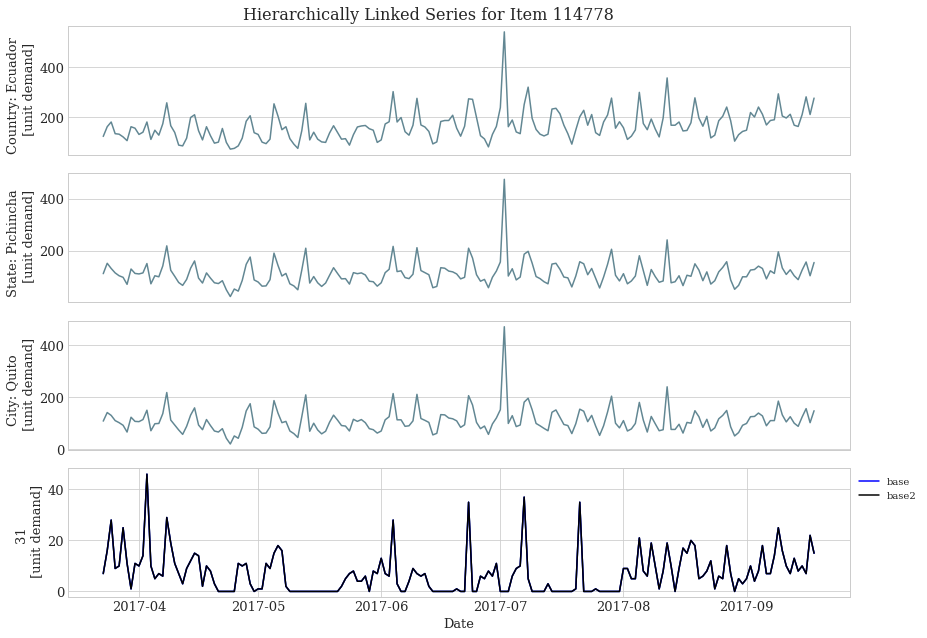

In [ ]:
# def plot_hierarchically_linked_data(data, item_idx, store_idx, 
#                                     n_days=30*5, plot_file=None):
    
#     # This plots validate the S/X/Y_bottom
#     # We check for the sinchronization of features with Y_bottom
#     # We do the same for Y_agg, to check correct linkage
#     assert store_idx < 94 and store_idx>=0
    
#     # Hierarchically linked target data and labels
#     # [Total, State, City] [0, 1, 2]
#     linked_idxs = data['hier_linked_idxs'][store_idx]
    
#     # Base series and its label idx \in {0,...,304}
#     # n_agg=1+16+22=39
#     Y_hier  = data['Y_hier'][item_idx, :,:]
#     Y_base  = data['Y_hier'][item_idx, store_idx+39,:]
#     Y_base2 = data['Y'][item_idx,store_idx,:]
    
#     hier_labels = data['hier_labels']
#     label       = data['items_ids'][item_idx]
        
#     x_plot = data['dates'][:] #-12] # Skip future dates
    
#     fig, axs = plt.subplots(len(linked_idxs), 1, figsize=(12, 9)) #9
#     for idx, linked_idx in enumerate(linked_idxs):
#         axs[idx].plot(x_plot[-n_days:], Y_hier[linked_idx,-n_days:],
#                       color='#628793', linewidth=1.5)
#         plot_label = hier_labels[linked_idx]
#         plot_label = plot_label.replace('[', '')
#         plot_label = plot_label.replace(']', '')
#         plot_label = plot_label.replace('_', ': ').title()
#         axs[idx].set_ylabel(f'{plot_label}  \n [unit demand]', fontsize=13)
#         axs[idx].tick_params(labelsize=13)
        
#         if idx < len(linked_idxs)-1:
#             axs[idx].set_xticks([])
    
#     # Checking that Y_bottom and Y_hier match
#     axs[3].plot(x_plot[-n_days:], Y_base[-n_days:],
#                 color = 'blue', linewidth=1.5, label='base')
#     axs[3].plot(x_plot[-n_days:], Y_base2[-n_days:],
#                 color = 'black', linewidth=1.5, label='base2')
    
#     axs[3].set_xlabel('Date', fontsize=13)
#     axs[3].set_ylabel(f'{plot_label} \n [unit demand]', fontsize=13)
#     axs[3].tick_params(labelsize=13)
    
#     plt.suptitle(f'Hierarchically Linked Series for Item {label}', fontsize=16)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.95)
#     plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#     if plot_file is not None:
#         plt.savefig(plot_file, bbox_inches='tight')
#     plt.show()
#     plt.close()
    
# item_idx  = 0
# store_idx = 31
# plot_hierarchically_linked_data(data=data, 
#                                 item_idx=item_idx, store_idx=store_idx, 
#                                 n_days=30*6, plot_file=None)

#### Checking Geographically linked data

In [ ]:
# data['xcols_futr_agg']

['dcoilwtico',
 'day_of_week',
 'day_of_month',
 'month',
 'dist2_[Primer dia del ano]',
 'dist2_[Carnaval]',
 'dist2_[Viernes Santo]',
 'dist2_[Dia del Trabajo]',
 'dist2_[Batalla de Pichincha]',
 'dist2_[Primer Grito de Independencia]',
 'dist2_[Traslado Independencia de Guayaquil]',
 'dist2_[Dia de Difuntos]',
 'dist2_[Independencia de Cuenca]',
 'dist2_[Navidad]',
 'dist2_[Independencia de Guayaquil]',
 'dist2_[Traslado Batalla de Pichincha]',
 'dist2_[Traslado Primer Grito de Independencia]',
 'dist2_[Traslado Primer dia del ano]']

<a name="cell-4"></a>
## 4. HierTimeseriesDataset Validation

In [ ]:
# from torch.utils.data import DataLoader

# from neuralforecast.data.datasets.favorita import Favorita
# from neuralforecast.data.hiertsdataset import HierTimeseriesDataset

# directory = './data/hierarchical/favorita'
# Favorita.preprocess_data(directory=directory, sample_size=100, verbose=False)
# data = Favorita.load_process(directory=directory, sample_size=100, verbose=True)

Code block 'Reading data           ' took:	1.35650 seconds
Code block 'Process temporal_agg   ' took:	0.34115 seconds
Code block 'Process static_agg     ' took:	0.00069 seconds
Code block 'Process temporal_bottom' took:	0.70723 seconds
Code block 'Process static_bottom  ' took:	0.00141 seconds
Code block 'Hier constraints       ' took:	0.93466 seconds
Code block 'Final processing       ' took:	1.34764 seconds


TODO: add weights as prob for loss?
TODO: do bfill onpromotion rather than ffill (future)


Total days 1722, train 1654 validation 34, test 34
Whole dates: 		 [2013-01-01 00:00:00, 2017-09-18 00:00:00]
Validation dates: 	 [2017-07-13 00:00:00, 2017-08-15 00:00:00]
Test dates: 		 [2017-08-16 00:00:00, 2017-09-18 00:00:00]


                                   BOTTOM
S.shape (n_items,n_stores,n_features):        	(100, 54, 41)
X.shape (n_items,n_stores,n_features,n_time): 	(100, 54, 9, 1723)
Y.shape (n_items,n_stores,n_time):            	(100, 54, 1688)
                            

In [ ]:
# T = 1688-34-34
# H = 34

# train_dataset = HierTimeseriesDataset(# Bottom data
#                                       X=data['X'], 
#                                       S=data['S'], 
#                                       Y=data['Y'],
#                                       xcols=data['xcols'],
#                                       xcols_hist=data['xcols_hist'],
#                                       xcols_futr=data['xcols_futr'],
#                                       xcols_sample_mask=data['xcols_sample_mask'],
#                                       xcols_available_mask=data['xcols_available_mask'],
#                                       dates = data['dates'],
#                                       # Aggregated data
#                                       X_agg=data['X_agg'], 
#                                       S_agg=data['S_agg'], 
#                                       Y_agg=data['Y_agg'],
#                                       xcols_agg=data['xcols_agg'],
#                                       xcols_hist_agg=data['xcols_hist_agg'],
#                                       xcols_futr_agg=data['xcols_futr_agg'],
#                                       # Generator parameters
#                                       T0=H,T=T,H=H)

# valid_dataset = HierTimeseriesDataset(# Bottom data
#                                       X=data['X'], 
#                                       S=data['S'], 
#                                       Y=data['Y'],
#                                       xcols=data['xcols'],
#                                       xcols_hist=data['xcols_hist'],
#                                       xcols_futr=data['xcols_futr'],
#                                       xcols_sample_mask=data['xcols_sample_mask'],
#                                       xcols_available_mask=data['xcols_available_mask'], 
#                                       dates = data['dates'],
#                                       # Aggregated data
#                                       X_agg=data['X_agg'], 
#                                       S_agg=data['S_agg'], 
#                                       Y_agg=data['Y_agg'],
#                                       xcols_agg=data['xcols_agg'],
#                                       xcols_hist_agg=data['xcols_hist_agg'],
#                                       xcols_futr_agg=data['xcols_futr_agg'],
#                                       # Generator parameters
#                                       T0=2*H,T=T,H=H,
#                                       lastwindow_mask=True)

# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
# valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

# train_batch = next(iter(train_dataloader))
# valid_batch = next(iter(valid_dataloader))

# for key in train_batch.keys():
#     print(f'{key}.shape', train_batch[key].shape)

Y.shape torch.Size([4, 54, 1619])
S.shape torch.Size([4, 54, 41])
X.shape torch.Size([4, 54, 1, 1620])
F.shape torch.Size([4, 54, 6, 1654])
sample_mask.shape torch.Size([4, 54, 1619])
available_mask.shape torch.Size([4, 54, 1619])
Y_agg.shape torch.Size([4, 1, 1619])
S_agg.shape torch.Size([4, 66])
X_agg.shape torch.Size([4, 73, 1620])
F_agg.shape torch.Size([4, 18, 1654])


### 4.1 Examinate HierTimeSeriesDataset aggregate batch
1. Examinate the hierarchically linked Y_agg series.
2. Examinate the alignment between Y_agg and X_agg_futr.
3. Validate the S_agg dummies generated from H constraints matrix.

In [ ]:
# data['xcols_futr']

['onpromotion',
 'is_original',
 'day_of_week',
 'day_of_month',
 'dist2_[Primer dia del ano]',
 'dist2_[Navidad]']

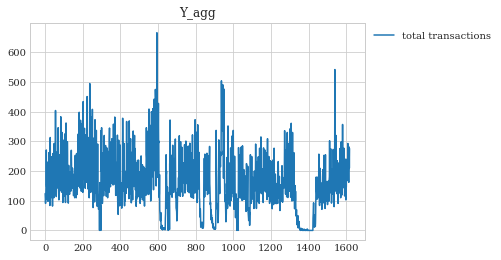

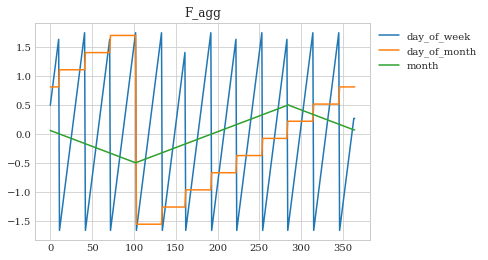

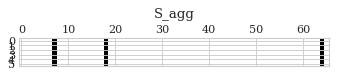

In [ ]:
# # Parse batch and filter for first entry
# batch = valid_batch
# item_idx = 0
# S_agg = batch['S_agg'][item_idx]
# Y_agg = batch['Y_agg'][item_idx]
# X_agg = batch['X_agg'][item_idx]
# F_agg = batch['F_agg'][item_idx]

# #------------------ Hierarchical Y_agg ----------------#
# plt.plot(Y_agg[0,:], label='total transactions')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.title('Y_agg')
# plt.show()
# plt.close()

# #---------------- X_agg_futr ----------------#
# day_of_week_idx  = xcols_agg.get_loc('day_of_week')
# day_of_month_idx = xcols_agg.get_loc('day_of_month')
# month_idx = xcols_agg.get_loc('month')

# plt.plot(F_agg[day_of_week_idx,-365:], label='day_of_week')
# plt.plot(F_agg[day_of_month_idx,-365:], label='day_of_month')
# plt.plot(F_agg[month_idx,-365:], label='month')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.title('F_agg')
# plt.show()
# plt.close()

# # #---------------- S_agg ----------------#
# plt.figure(num=1, figsize=(5, 5), dpi=80, facecolor='w')
# plt.spy(np.repeat(S_agg[None,:], 6, axis=0))
# plt.title('S_agg')
# plt.show()
# plt.close()

### 4.2 Examinate HierTimeSeriesDataset bottom batch
1. Examinate the alignment between Y_bottom, S_bottom and X_bottom_futr.
2. Validate batch Seq2Seq structure between X_bottom vs Y_bottom.

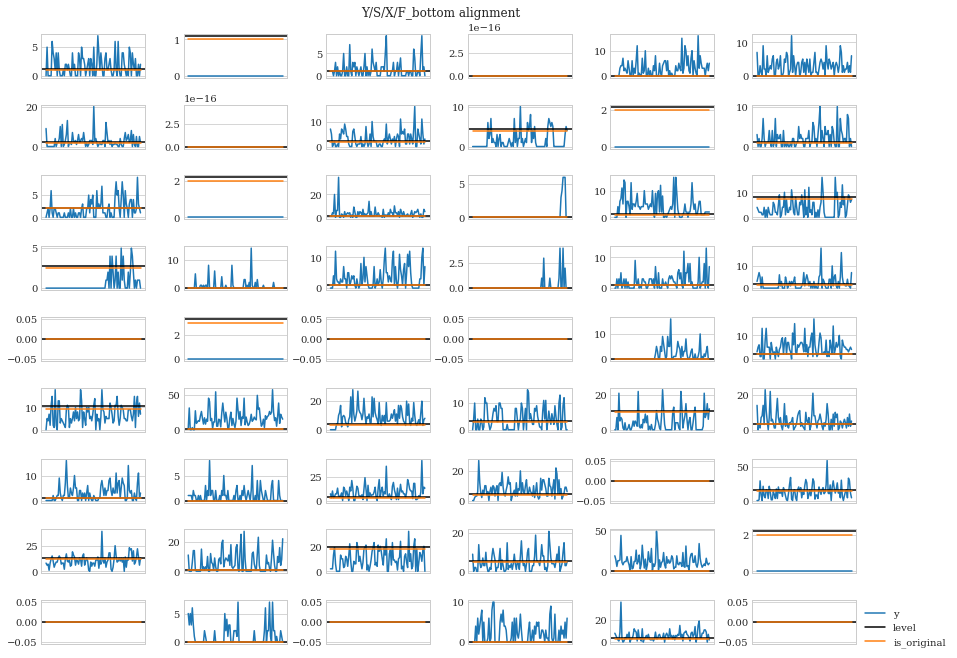



Y_bottom.shape torch.Size([54, 1619])
Y_bottom[idx,start:end].shape torch.Size([300])
dates[start:end].shape (300,)


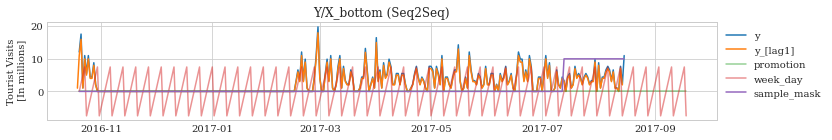

In [ ]:
# # Parse batch and filter for first entry
# # batch = train_batch
# # dates = train_dataset.dates
# item_idx = 0
# batch = valid_batch
# dates = valid_dataset.dates
# S_bottom = batch['S'][item_idx]
# Y_bottom = batch['Y'][item_idx]
# X_bottom = batch['X'][item_idx]
# F_bottom = batch['F'][item_idx]
# sample_mask = batch['sample_mask'][item_idx]

# # #---------------- Y/S/X_bottom alignment ----------------#

# n_days = 60+34 #60+34 #3*365
# fig, axs = plt.subplots(9,6, figsize=(12, 9))
# fig.tight_layout()

# for idx, store in enumerate(np.arange(1,55)):
#     row_idx = idx // 6
#     col_idx = idx % 6
    
#     axs[row_idx][col_idx].plot(dates[1:n_days+1],
#                                Y_bottom[idx,:n_days], label='y')
#     axs[row_idx][col_idx].set_xticks([])
#     axs[row_idx][col_idx].axhline(y=S_bottom[idx,-2]*1.1,
#                 label='level', color='black')
#     axs[row_idx][col_idx].plot(dates[1:n_days+1],
#                                F_bottom[idx,1,:n_days], label='is_original')

# plt.suptitle('Y/S/X/F_bottom alignment ', y=1.02)
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.show()
# plt.close()

# #---------------- Y/X_bottom Seq2Seq structure ----------------#
# idx   = 32
# start = 1688-34-34-1-300
# end   = 1688-34-34-1
# H = 34
# print('\n')
# plt.figure(figsize=(12, 1.8))

# print('Y_bottom.shape', Y_bottom.shape)
# print('Y_bottom[idx,start:end].shape', Y_bottom[idx,start:end].shape)
# print('dates[start:end].shape', dates[start:end].shape)

# plt.plot(dates[start:end],     Y_bottom[idx,start:end]*1.1, label='y')
# plt.plot(dates[start-1:end-1], X_bottom[idx,0,start:end], label='y_[lag1]')
# plt.plot(dates[start:end+H],   F_bottom[idx,0,start:end+H]*Y_bottom[idx,-1]*2, 
#          alpha=0.5, label='promotion')
# plt.plot(dates[start:end+H],   F_bottom[idx,2,start:end+H]*Y_bottom[idx,-1]*0.5, 
#          alpha=0.5, label='week_day')
# plt.plot(dates[start:end],     sample_mask[idx,start:end]*Y_bottom[idx,-1], label='sample_mask')
# plt.ylabel('Tourist Visits\n [In millions]')
# plt.title('Y/X_bottom (Seq2Seq)')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.show()
# plt.close()